In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

from collections import Counter

sstyle = "seaborn-poster"
plt.style.use(sstyle)
plt.rc('font',family = 'serif')

pd.set_option('display.max_columns', None)
colors_ = sns.color_palette('viridis', 15)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

/tmp/ipykernel_22569/1659174860.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(sstyle)


In [2]:
class MyCounter(Counter):
    def __str__(self):
        return "\n".join('{}: {}'.format(k, v) for k, v in sorted(self.items()))



# <center>Cornerstone for Interpretation | Physical Particles</center>

**NORMALIZED ION GYRORADIUS**

$$
    \rho_* = \frac{\rho_i}{a} \propto (M_{eff}T)^{1/2}B_t^{-1}
$$

**NORMALIZED PLASMA PRESSURE**

$$
    \beta_t = \frac{2\mu_0 p}{B_t^2} \propto nTB_t^{-2}
$$

**NORMALIZED ION COLLISION FREQUENCY**

$$
    \nu_* = \nu_{ii}\left(\frac{m_i}{eT}\right)^{1/2}\left(\frac{R_{geo}}{a}\right)^{3/2}q_{cyl}R_{geo}
$$

**SAFETY FACTOR -- CYLINDRICAL APPROXIMATION**

$$
    q_{cyl} = \frac{2\pi a^2 \kappa_a B_t}{\mu_0 R_{geo}I_P}
$$

Where $p,n$ [m^{-3}] and $T$ [eV] are the volume-averaged pressure, density and temperature; respectively. 

In [3]:
group1 = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")
group1 = group1[group1.frequency > 0] # otherwise alpha-R ~ 1
group2 = pd.read_csv(path+"IDs/alpha_one/R_ids_alpha_0.9996.csv")
group3 = pd.read_csv(path+"IDs/alpha_two/R_ids_alpha_1.9930.csv")

DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False)
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

DB2 = pd.read_csv(path+"DB2P8.csv")

# There are shots missing in DB5 from DB2P8
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

### Categorical Data | Preprocessing

In [4]:
TOK_characteristics = ["DIVNAME","WALMAT","DIVMAT","LIMMAT"]
categorical = ["PREMAG","HYBRID","CONFIG","ELMTYPE","ECHMODE",
               "ICSCHEME","AUXHEAT","EVAP","PELLET"] + TOK_characteristics 

DB5[categorical] = DB5[categorical].fillna('UNKNOWN')
DB5["DIVNAME"]   = DB5["DIVNAME"].str.replace("NONAME","UNKNOWN",regex=False)


DB5["PELLET"] = DB5["PELLET"].str.replace("GP_D","D",regex=False)
DB5["PELLET"] = DB5["PELLET"].str.replace("GP_H","H",regex=False)

DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("CC","C",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI1","TI12",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI2","TI12",regex=False)

DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-I)|(DV-IPRE)|(DV-IPOST)",
                                            "DV-I",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-II)|(DV-IIc)|(DV-II-C)|(DV-IIb)|(DV-IIc)|(DV-IId)|(DV-IId)",
                                            "DV-II",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(MARK0)|(MARKI)|(MARKIIA)|(MARKGB)|(MARKGBSR)|"+
                                            "(MARKIA)|(MARKIAP)|(MARKSR)|(MARKA)|(MARKP)",
                                            "MARK",regex=True)

DB5["ICSCHEME"]   = DB5["ICSCHEME"].str.replace("OFF","NONE",regex=False)

DB5["EVAP"] = DB5["EVAP"].str.replace("CARBH","C-H",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("CARB","C",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("BOROC","C-BO",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("(BOROA)|(BOROB)|(BOROX)|(BOR)","BO",regex=True)
#DB5["EVAP"] = DB5["EVAP"].str.replace("DECABOA","C",regex=True)

#### Physical Variables

In [5]:
DB5["MINORRAD"] = DB5["EPS"]*DB5["RGEO"] 
DB5["BOHM_DIFFUSIVITY"] = (DB5["MINORRAD"]*DB5["MINORRAD"])/DB5["TAUBOHM"] 

### Making sure datas represent correct alpha-R

In [6]:
data1 = DB5[ DB5.id.isin(group1.id.values)] # alpha_R -- 0.6558 --> when considering DB2 for calculation
data2 = DB5[~DB5.id.isin(group1.id.values)] # alpha_R -- 2.1638 --> when considering DB2 for calculation
data2 = data2[~data2.id.isin(DB2.id.values)]# Removing DB2, because most of these shots have missing info

In [7]:
def get_regression(_R, withDB2=False):
    """
    ASSUMING DATA IS ***NOT*** GIVEN IN LOG-SCALE
    """
    if withDB2:
        data = _R.copy()
    else:     
        data = pd.concat([DB2, _R],
                         axis=0, 
                         ignore_index=True
                        )
    Y_ = data[["TAUTH"]].apply(np.log).to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs].apply(np.abs).apply(np.log)
    _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

d_, r_, np_ = get_regression(data2, withDB2=False)

In [8]:
# Needed for Improved Visualization in Plots

hue_order_ICSCHEME = dict(zip(sorted(data1["ICSCHEME"].unique()), colors_[:len(data1["ICSCHEME"].unique())]))
hue_order_ELMTYPE  = dict(zip(sorted(data1["ELMTYPE"].unique()), colors_[:len(data1["ELMTYPE"].unique())]))
hue_order_HYBRID   = dict(zip(sorted(data1["HYBRID"].unique()), colors_[:len(data1["HYBRID"].unique())]))
hue_order_AUXHEAT  = dict(zip(sorted(data1["AUXHEAT"].unique()), colors_[:len(data1["AUXHEAT"].unique())]))
hue_order_DIVMAT   = dict(zip(sorted(data1["DIVMAT"].unique()), colors_[:len(data1["DIVMAT"].unique())]))
hue_order_WALMAT   = dict(zip(sorted(data1["WALMAT"].unique()), colors_[:len(data1["WALMAT"].unique())]))
hue_order_EVAP     = dict(zip(sorted(data1["EVAP"].unique()), colors_[:len(data1["EVAP"].unique())]))
hue_order_ECHMODE  = dict(zip(sorted(data1["ECHMODE"].unique()), colors_[:len(data1["ECHMODE"].unique())]))


# <center>GYRO REDUCED BOHM ENERGY CONFINEMENT TIME | DIFFUSIVITY</center>



[Following is an answer from ChatGPT](https://chat.openai.com)

In the field of plasma physics and fusion research, the Bohm-normalized diffusivity refers to a characteristic parameter that quantifies the transport of heat or particles in a tokamak, which is a type of magnetic confinement fusion device. It is named after physicist David Bohm, who made significant contributions to the study of plasma physics.

The Bohm-normalized diffusivity, often denoted as $\chi_{\text{Bohm}}$, is defined as the ratio of the actual diffusivity in the tokamak, denoted as $\chi$, to a reference diffusivity known as the Bohm diffusivity, denoted as $\chi_{\text{B}}$. Mathematically, it is expressed as:

$$
    \chi_{\text{Bohm}} = \frac{\chi}{\chi_{\text{B}}}
$$
 

The Bohm diffusivity is a fundamental parameter that arises from theoretical considerations and is often used as a reference diffusivity in plasma physics. It represents an estimate of the minimal transport that can occur due to the random motion of charged particles in a plasma.

The Bohm-normalized diffusivity is an important parameter in the study of plasma transport in tokamaks, as it provides insights into the efficiency of heat and particle transport in the plasma. A value of $\chi_{\text{Bohm}}$ close to 1 indicates that the actual diffusivity is similar to the Bohm diffusivity, suggesting that transport in the tokamak is close to the minimal level expected from random particle motion. Values of $\chi_{\text{Bohm}}$ significantly different from 1 can indicate the presence of anomalous transport, which is transport that deviates from the expected behavior based on classical physics and is often associated with the presence of turbulence in the plasma. Understanding and controlling plasma transport, including the Bohm-normalized diffusivity, is a key challenge in achieving practical magnetic confinement fusion for future energy production.

---

Bohm time $\tau_B = a^2/\chi_B$; with $\chi_B \propto T/B_t$; since, $\tau_B\propto\omega_i^{-1}\rho^{-2}$

In [9]:
physical_var = ["RHOSTAR", "BETASTAR", "NUSTAR", "Q95", "TAUBOHM"]

In [10]:
DB5["BOHM_DIFFUSIVITY"].describe()

count    6252.000000
mean        4.972984
std        10.730755
min         0.205030
25%         1.980823
50%         2.681531
75%         3.811691
max       162.173657
Name: BOHM_DIFFUSIVITY, dtype: float64

[Answer from ChatGPT](https://chat.openai.com/chat/b56f6e6e-ae04-4d4b-a598-02fd4ef155f9)

The Bohm diffusivity is a parameter that characterizes the rate at which plasma particles, such as ions and electrons, diffuse across the magnetic field lines in a tokamak. It is typically denoted by the symbol $\chi_{\text{Bohm}}$, and its value depends on the specific plasma conditions and the magnetic field strength.

If the Bohm diffusivity takes a value of 100, it would indicate that the plasma particles are diffusing at a relatively high rate across the magnetic field lines. This could have several implications for the behavior of the plasma in a tokamak:

1. **Enhanced Transport**: A higher Bohm diffusivity means that plasma particles are more likely to escape from the confined region of the tokamak plasma and mix with the surrounding plasma or be lost to the vessel walls. This could result in increased transport of energy, particles, and momentum across the magnetic field lines, which can impact the confinement and performance of the plasma. Enhanced transport can result in reduced plasma temperature and density profiles, and lower plasma performance.

2. Reduced confinement: Higher Bohm diffusivity could lead to reduced confinement of the plasma, as particles can more easily escape from the confined region of the plasma. This can result in lower plasma temperatures and densities, and reduced energy confinement time, which are important parameters for achieving high-performance tokamak plasmas.


### Temperature and Density

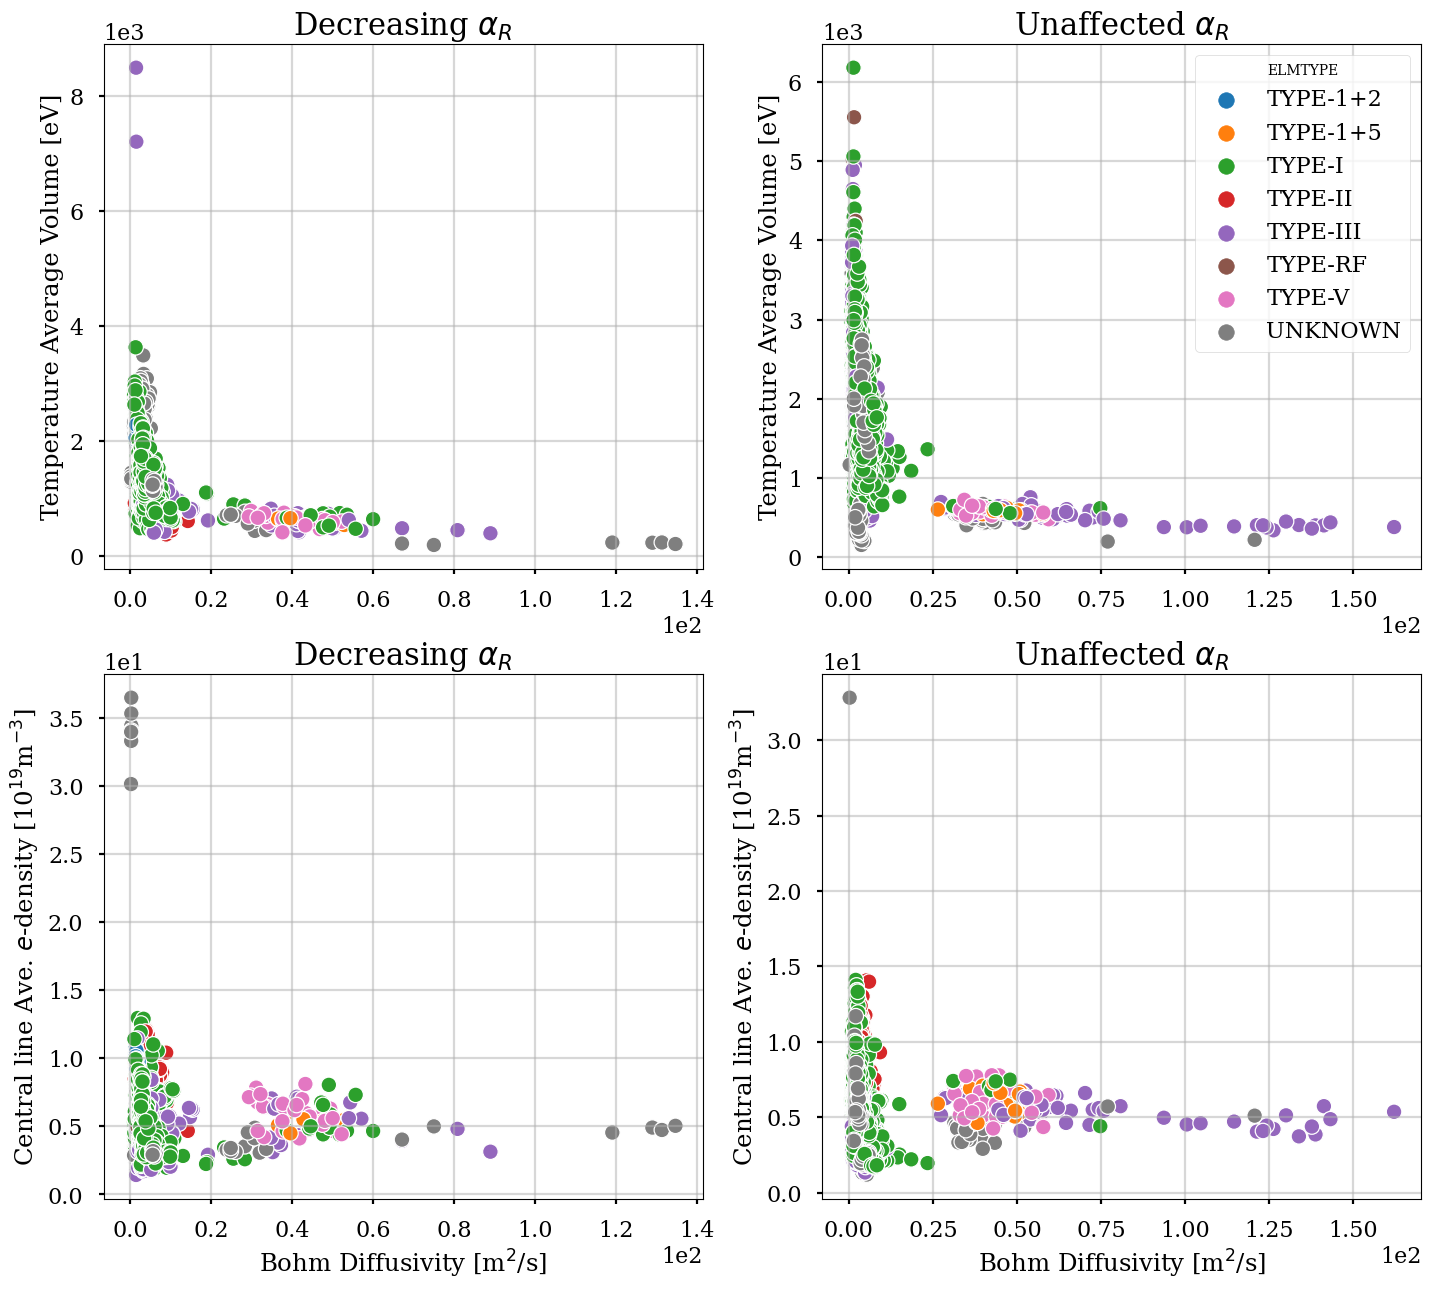

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(17, 15))


sns.scatterplot(data=data1, x="BOHM_DIFFUSIVITY", y="TAV", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data1, x="BOHM_DIFFUSIVITY", y="NEL", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])


sns.scatterplot(data=data2, x="BOHM_DIFFUSIVITY", y="TAV", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data2, x="BOHM_DIFFUSIVITY", y="NEL", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,1])

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

axs[0,0].legend().remove()
#axs[0,1].legend().remove()
axs[1,0].legend().remove()
axs[1,1].legend().remove()

axs[0,0].set_title("Decreasing $\\alpha_R$", fontsize=22)
axs[1,0].set_title("Decreasing $\\alpha_R$", fontsize=22)
axs[0,1].set_title("Unaffected $\\alpha_R$", fontsize=22)
axs[1,1].set_title("Unaffected $\\alpha_R$", fontsize=22)

axs[0,0].grid(alpha=0.5)
axs[1,0].grid(alpha=0.5)
axs[0,1].grid(alpha=0.5)
axs[1,1].grid(alpha=0.5)


axs[0,0].set_xlabel("")
axs[0,1].set_xlabel("")
axs[1,0].set_xlabel("Bohm Diffusivity [m$^2$/s]")
axs[1,1].set_xlabel("Bohm Diffusivity [m$^2$/s]")

axs[0,0].set_ylabel("Temperature Average Volume [eV]")
axs[0,1].set_ylabel("Temperature Average Volume [eV]")

axs[1,0].set_ylabel("Central line Ave. $e$-density [10$^{19}$m$^{-3}$]")
axs[1,1].set_ylabel("Central line Ave. $e$-density [10$^{19}$m$^{-3}$]");

### Confinement Time

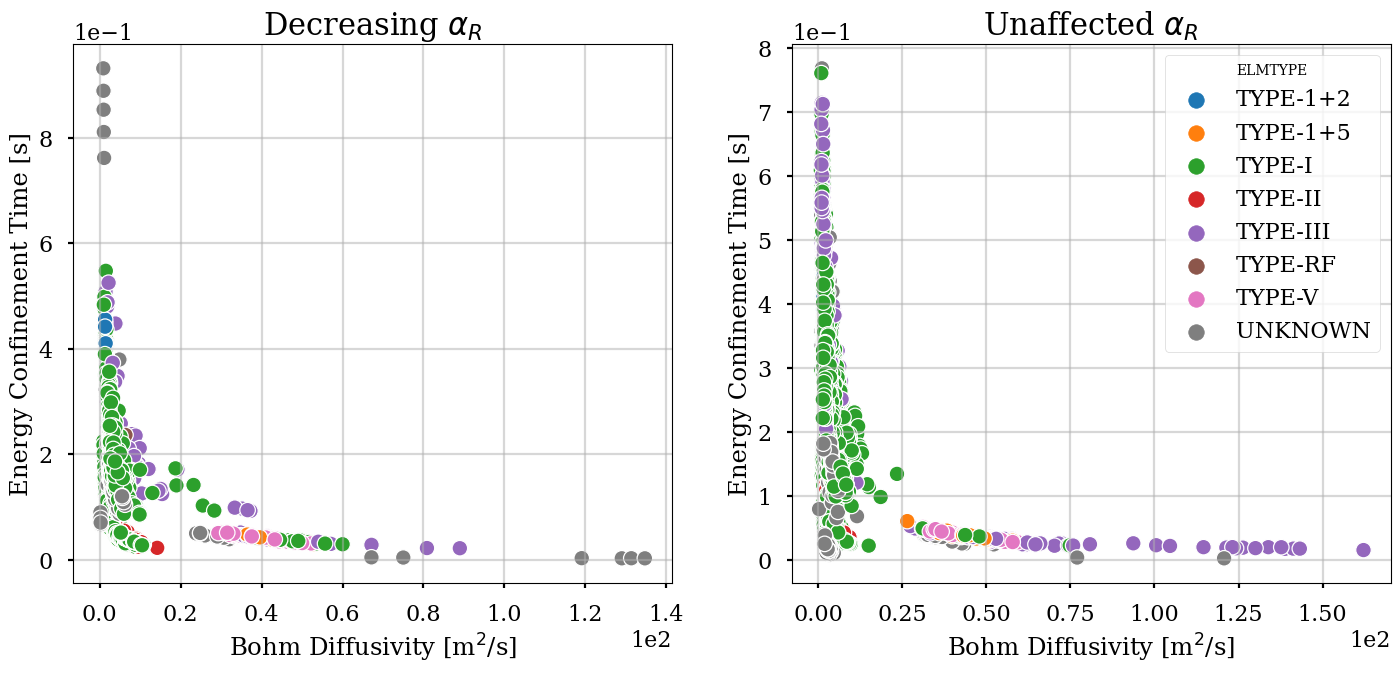

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(17, 7))


sns.scatterplot(data=data1, x="BOHM_DIFFUSIVITY", y="TAUTH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0])
sns.scatterplot(data=data2, x="BOHM_DIFFUSIVITY", y="TAUTH", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1])


axs[0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))


axs[0].legend().remove()
#axs[1].legend().remove()

axs[0].set_title("Decreasing $\\alpha_R$", fontsize=22)
axs[1].set_title("Unaffected $\\alpha_R$", fontsize=22)

axs[0].grid(alpha=0.5)
axs[1].grid(alpha=0.5)

axs[0].set_ylabel("Energy Confinement Time [s]")
axs[1].set_ylabel("Energy Confinement Time [s]")

axs[0].set_xlabel("Bohm Diffusivity [m$^2$/s]")
axs[1].set_xlabel("Bohm Diffusivity [m$^2$/s]");

3. Reduced stability: Enhanced transport due to a higher Bohm diffusivity can also affect the stability of the plasma. Rapid changes in plasma density and temperature profiles due to increased transport can induce instabilities, such as edge localized modes (ELMs) or other MHD (magnetohydrodynamic) modes, which can degrade plasma confinement and disrupt plasma operations.

In regimes where $\nu_*$ is high, Coulomb collisions can be significant, leading to enhanced transport and reduced energy confinement time. On the other hand, in regimes where $\nu_*$ is low, the ions may be more collisionless and exhibit gyrokinetic behavior in the tokamak plasma.

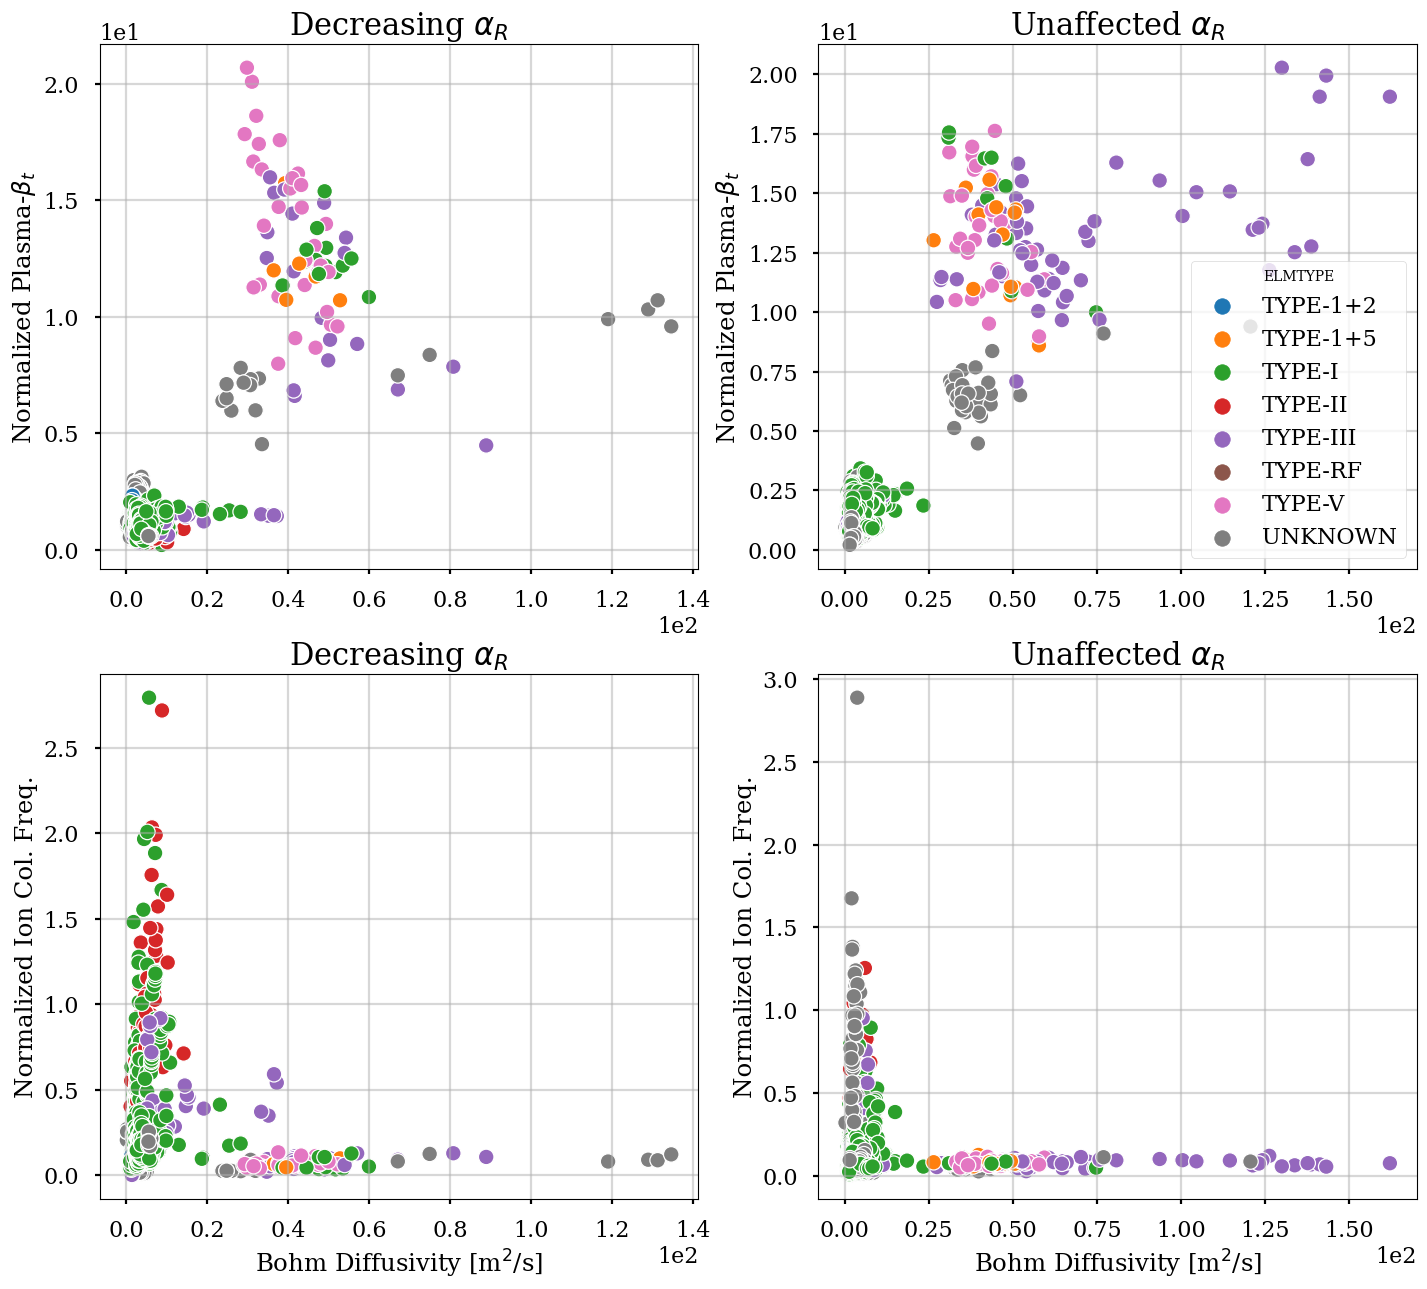

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(17, 15))


sns.scatterplot(data=data1, x="BOHM_DIFFUSIVITY", y="BETASTAR", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,0])
sns.scatterplot(data=data1, x="BOHM_DIFFUSIVITY", y="NUSTAR", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,0])


sns.scatterplot(data=data2, x="BOHM_DIFFUSIVITY", y="BETASTAR", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[0,1])
sns.scatterplot(data=data2, x="BOHM_DIFFUSIVITY", y="NUSTAR", hue="ELMTYPE",hue_order=hue_order_ELMTYPE, ax=axs[1,1])

axs[0,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[0,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

axs[1,0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
axs[1,1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))

axs[0,0].legend().remove()
#axs[0,1].legend().remove()
axs[1,0].legend().remove()
axs[1,1].legend().remove()

axs[0,0].set_title("Decreasing $\\alpha_R$", fontsize=22)
axs[1,0].set_title("Decreasing $\\alpha_R$", fontsize=22)
axs[0,1].set_title("Unaffected $\\alpha_R$", fontsize=22)
axs[1,1].set_title("Unaffected $\\alpha_R$", fontsize=22)

axs[0,0].grid(alpha=0.5)
axs[1,0].grid(alpha=0.5)
axs[0,1].grid(alpha=0.5)
axs[1,1].grid(alpha=0.5)

axs[0,0].set_xlabel("")
axs[0,1].set_xlabel("")
axs[1,0].set_xlabel("Bohm Diffusivity [m$^2$/s]")
axs[1,1].set_xlabel("Bohm Diffusivity [m$^2$/s]")

axs[0,0].set_ylabel("Normalized Plasma-$\\beta_t$")
axs[0,1].set_ylabel("Normalized Plasma-$\\beta_t$")

axs[1,0].set_ylabel("Normalized Ion Col. Freq.")
axs[1,1].set_ylabel("Normalized Ion Col. Freq.");